In [475]:
import re
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import urllib.request
from gpt_download import download_and_load_gpt2
import numpy as np

In [294]:
input_file_path = 'data/the-verdict.txt'

In [295]:
with open(input_file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

print(f"Length of raw text: {len(raw_text)} characters")
print(raw_text[:100])  

Length of raw text: 20479 characters
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


#### Raw text to tokens

In [296]:
preprocessed = re.split(r'([,.;?_!"()\']|--|\s)', raw_text) # split on commas, periods, question amrks, quotation marks, double dashes and whitespace
preprocessed = [item for item in preprocessed if item.strip()] # remove whitespace-only tokens
len(preprocessed)

4670

In [297]:
preprocessed[:30]

['I',
 'HAD',
 'always',
 'thought',
 'Jack',
 'Gisburn',
 'rather',
 'a',
 'cheap',
 'genius',
 '--',
 'though',
 'a',
 'good',
 'fellow',
 'enough',
 '--',
 'so',
 'it',
 'was',
 'no',
 'great',
 'surprise',
 'to',
 'me',
 'to',
 'hear',
 'that',
 ',',
 'in']

#### Token to Token IDs

In [298]:
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(f"Vocab size: {vocab_size} tokens")

Vocab size: 1146 tokens


In [299]:
vocab = {token: integer for integer, token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    if i < 50:
        print(item)
    else:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindle:', 43)
('Grindles', 44)
('HAD', 45)
('Had', 46)
('Hang', 47)
('Has', 48)
('He', 49)


#### Text tokenizer class

In [300]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {integer: token for token, integer in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.;?_!"()\']|--|\s)', text)
        preprocessed = [item for item in preprocessed if item.strip()]
        token_ids = [self.str_to_int[token] for token in preprocessed]
        return token_ids
    
    def decode(self, token_ids):
        text = ' '.join([self.int_to_str[token_id] for token_id in token_ids])
        text = re.sub(r'\s+([,.;?_!"()\'])', r'\1', text) # remove space before punctuation
        return text


In [301]:
tokenizer = SimpleTokenizerV1(vocab)

In [302]:
text = """"It's the last he painted, you know," Mrs. Gisburn said"""
ids = tokenizer.encode(text)
print(ids)

[1, 57, 2, 861, 1002, 607, 536, 755, 5, 1142, 601, 5, 1, 68, 7, 38, 862]


In [303]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said


#### Tokenizer handles unknown words

In [304]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token: integer for integer, token in enumerate(all_tokens)}

In [305]:
print(len(vocab.items()))

1148


In [306]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1143)
('your', 1144)
('yourself', 1145)
('<|endoftext|>', 1146)
('<|unk|>', 1147)


In [307]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {integer: token for token, integer in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.;?_!"()\']|--|\s)', text)
        preprocessed = [item for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]

        token_ids = [self.str_to_int[token] for token in preprocessed]
        return token_ids
    
    def decode(self, token_ids):
        text = ' '.join([self.int_to_str[token_id] for token_id in token_ids])
        text = re.sub(r'\s+([,.;?_!"()\'])', r'\1', text) # remove space before punctuation
        return text

In [308]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join([text1, text2])
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [309]:
tokenizer = SimpleTokenizerV2(vocab)

In [310]:
print(tokenizer.encode(text))

[1147, 5, 357, 1142, 634, 989, 10, 1146, 56, 1002, 970, 998, 730, 1002, 1147, 7]


In [311]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


#### Byte Pair encoding

In [312]:
tokenizer = tiktoken.get_encoding("gpt2")

In [313]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 262, 20562, 13]


In [314]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


#### Data sampling with sliding window

In [315]:
with open(input_file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

enc_text = tokenizer.encode(raw_text)
print(f"Length of tokenized text: {len(enc_text)} tokens")

Length of tokenized text: 5145 tokens


In [316]:
enc_sample = enc_text[50:]

In [317]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size + 1]
print("Input sequence (x):", x)
print("Target sequence (y):     ", y)

Input sequence (x): [290, 4920, 2241, 287]
Target sequence (y):      [4920, 2241, 287, 257]


In [318]:
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "->", desired)

[290] -> 4920
[290, 4920] -> 2241
[290, 4920, 2241] -> 287
[290, 4920, 2241, 287] -> 257


In [319]:
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    

    print(tokenizer.decode(context), "->", tokenizer.decode([desired]))

 and ->  established
 and established ->  himself
 and established himself ->  in
 and established himself in ->  a


#### Dataset for batched inputs and targets

In [320]:
class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [321]:
def create_dataloader_v1(text, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(text, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

In [322]:
with open(input_file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False, drop_last=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [323]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [324]:
with open(input_file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False, drop_last=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("Targets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


#### Token embeddings


In [325]:
input_ids = torch.tensor([2,3,5,1])
vocab_size = 6
output_dim = 3


In [326]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [327]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [328]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


#### Positional encoding

In [329]:
output_dim = 256
vocab_size = 50257  # GPT-2 vocabulary size
token_embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=output_dim)

In [330]:
max_length = 4
batch_size = 8
dataloader = create_dataloader_v1(raw_text, batch_size=batch_size, max_length=max_length, stride=max_length, shuffle=False, drop_last=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs: \n", inputs)
print("Inputs shape:", inputs.shape)  # Expected: (batch_size, max_length)

Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Inputs shape: torch.Size([8, 4])


In [331]:
token_embeddings = token_embedding_layer(inputs)
print("Token Embeddings shape:", token_embeddings.shape)  

Token Embeddings shape: torch.Size([8, 4, 256])


In [332]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(num_embeddings=context_length, embedding_dim=output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print("Positional Embeddings shape:", pos_embeddings.shape)

Positional Embeddings shape: torch.Size([4, 256])


In [333]:
input_embeddings = token_embeddings + pos_embeddings
print("Input Embeddings shape:", input_embeddings.shape)

Input Embeddings shape: torch.Size([8, 4, 256])


#### Self attention without trainable weights

In [334]:
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your
     [0.55, 0.87, 0.66], # journey
     [0.57, 0.85, 0.64], # starts
     [0.22, 0.58, 0.33], # with 
     [0.77, 0.25, 0.10], # one
     [0.05, 0.80, 0.55]] # step
)

In [335]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(query, x_i)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [336]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention Weights:", attn_weights_2_tmp)
print("Sum: ", attn_weights_2_tmp.sum())

Attention Weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


In [337]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention Weights (naive softmax):", attn_weights_2_naive)
print("Sum: ", attn_weights_2_naive.sum())

Attention Weights (naive softmax): tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [338]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention Weights (torch.softmax):", attn_weights_2)
print("Sum: ", attn_weights_2.sum())

Attention Weights (torch.softmax): tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [339]:
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print("Context Vector:", context_vec_2)

Context Vector: tensor([0.4419, 0.6515, 0.5683])


In [340]:
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x_i, x_j)

# for loops are slower, matric multiplication does the same thing more efficiently
print("Attention Scores Matrix:\n", attn_scores)

Attention Scores Matrix:
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [341]:
attn_scores = inputs @ inputs.T
print("Attention Scores Matrix (using @ operator):\n", attn_scores)

Attention Scores Matrix (using @ operator):
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [342]:
attn_weights = torch.softmax(attn_scores, dim=1)
print("Attention Weights Matrix:\n", attn_weights)

Attention Weights Matrix:
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [343]:
attn_weights.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [344]:
all_context_vecs = attn_weights @ inputs
print("All Context Vectors:\n", all_context_vecs)

All Context Vectors:
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [345]:
print("Previous Context Vectors:\n", context_vec_2)

Previous Context Vectors:
 tensor([0.4419, 0.6515, 0.5683])


#### Self attention with trainable weights

In [346]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [347]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.randn(d_in, d_out), requires_grad=False) # requires_grad=False since we are not training
W_key = torch.nn.Parameter(torch.randn(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.randn(d_in, d_out), requires_grad=False)

In [348]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print("Query Vector:\n", query_2)

Query Vector:
 tensor([-1.1729, -0.0048])


In [349]:
keys = inputs @ W_key
values = inputs @ W_value
print("Keys shape:\n", keys.shape)
print("Values shape:\n", values.shape)

Keys shape:
 torch.Size([6, 2])
Values shape:
 torch.Size([6, 2])


In [350]:
keys_2 = keys[1]
attn_scores_22 = query_2.dot(keys_2)
print("Attention Scores (Query 2 vs Key 2):\n", attn_scores_22)

Attention Scores (Query 2 vs Key 2):
 tensor(0.1376)


In [351]:
attn_scores_2 = query_2 @ keys.T
print("Attention Scores (Query 2 vs All Keys):\n", attn_scores_2)

Attention Scores (Query 2 vs All Keys):
 tensor([ 0.2172,  0.1376,  0.1730, -0.0491,  0.7616, -0.3809])


In [352]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print("Attention Weights (Query 2 vs All Keys):\n", attn_weights_2)

Attention Weights (Query 2 vs All Keys):
 tensor([0.1704, 0.1611, 0.1652, 0.1412, 0.2505, 0.1117])


In [353]:
context_vec_2 = attn_weights_2 @ values
print("Context Vector (Query 2):\n", context_vec_2)

Context Vector (Query 2):
 tensor([0.2854, 0.4081])


In [354]:
class SelfAttentionV1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super(SelfAttentionV1, self).__init__()
        self.W_query = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.randn(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.randn(d_in, d_out))

    def forward(self, inputs):
        queries = inputs @ self.W_query
        keys = inputs @ self.W_key
        values = inputs @ self.W_value

        d_k = keys.shape[-1]
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / d_k**0.5, dim=-1)

        context_vectors = attn_weights @ values
        return context_vectors

In [355]:
torch.manual_seed(123)
sa_v1 = SelfAttentionV1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2845, 0.4071],
        [0.2854, 0.4081],
        [0.2854, 0.4075],
        [0.2864, 0.3974],
        [0.2863, 0.3910],
        [0.2860, 0.4039]], grad_fn=<MmBackward0>)


#### Self attention using Linear layers

In [356]:
class SelfAttentionV2(torch.nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super(SelfAttentionV2, self).__init__()
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1], dim=-1)

        context_vectors = attn_weights @ values
        return context_vectors

In [357]:
torch.manual_seed(789)
sa_v2 = SelfAttentionV2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0748,  0.0699],
        [-0.0755,  0.0693],
        [-0.0755,  0.0692],
        [-0.0763,  0.0679],
        [-0.0766,  0.0675],
        [-0.0759,  0.0685]], grad_fn=<MmBackward0>)


#### Causal attention

In [358]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print("Attention weights:\n", attn_weights)

Attention weights:
 tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [359]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones((context_length, context_length)))
print("Causal Mask:\n", mask_simple)

Causal Mask:
 tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [360]:
masked_simple = attn_weights * mask_simple
print("Masked Attention Weights:\n", masked_simple)

Masked Attention Weights:
 tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [361]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print("Normalized Masked Attention Weights:\n", masked_simple_norm)

Normalized Masked Attention Weights:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [362]:
mask = torch.triu(torch.ones((context_length, context_length)), diagonal=1).bool()
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print("Masked Attention Scores:\n", masked)

Masked Attention Scores:
 tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [363]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print("Masked Attention Weights:\n", attn_weights)

Masked Attention Weights:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [364]:
context_vec = attn_weights @ values
print("Context Vectors with Causal Masking:\n", context_vec)

Context Vectors with Causal Masking:
 tensor([[ 0.1196, -0.3566],
        [ 0.2501,  0.0845],
        [ 0.2996,  0.2571],
        [ 0.2913,  0.3103],
        [ 0.2869,  0.3839],
        [ 0.2830,  0.3669]], grad_fn=<MmBackward0>)


In [365]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(p=0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [366]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


#### Casual Attention Class

In [367]:
batch = torch.stack([inputs, inputs], dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [368]:
class CasualAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, qkv_bias=False, dropout=0.1):
        super(CasualAttention, self).__init__()
        self.d_out = d_out
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)

        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vectors = attn_weights @ values
        return context_vectors

In [369]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length=context_length, dropout=0.0)
context_vecs = ca(batch)
print("Context vecs shape:", context_vecs.shape)

Context vecs shape: torch.Size([2, 6, 2])


#### Multi-head Attention

In [370]:
class MultiHeadAttentionWrapper(torch.nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout, qkv_bias=False):
        super(MultiHeadAttentionWrapper, self).__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.heads = torch.nn.ModuleList([
            CasualAttention(d_in, d_out, context_length, qkv_bias, dropout)
            for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [371]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, num_heads=2, context_length=context_length, dropout=0.0)
context_vecs = mha(batch)
print("Context vecs shape:", context_vecs.shape)
print("Context vecs:", context_vecs)

Context vecs shape: torch.Size([2, 6, 4])
Context vecs: tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)


#### Efficient Multi-head Attention


In [372]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super(MultiHeadAttention, self).__init__()
        assert d_out % num_heads == 0
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2).contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [373]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length=context_length, num_heads=2, dropout=0.0)
context_vecs = mha(batch)
print("Context vecs shape:", context_vecs.shape)
print("Context vecs:", context_vecs)

Context vecs shape: torch.Size([2, 6, 2])
Context vecs: tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)


#### GPT from scratch

In [374]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "n_layers": 12,
    "n_heads": 12,
    "emb_dim": 768,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [375]:
class DummyTransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super(DummyTransformerBlock, self).__init__()

    def forward(self, x):
        return x

In [376]:
class DummyGPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super(DummyGPTModel, self).__init__()
        self.tok_emb = torch.nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = torch.nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = torch.nn.Dropout(p=cfg["drop_rate"])
        self.trf_blocks = torch.nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = torch.nn.LayerNorm(cfg["emb_dim"])
        self.out_head = torch.nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [377]:
class DummyLayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(DummyLayerNorm, self).__init__()

    def forward(self, x):
        return x

In [378]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [379]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print("Output:", logits)

Output shape: torch.Size([2, 4, 50257])
Output: tensor([[[-0.7867,  0.2203, -0.4508,  ..., -0.9936, -0.1412, -0.2999],
         [-0.0788,  0.3004, -0.2935,  ...,  0.1583,  0.8917,  0.8230],
         [ 0.3708,  1.1126, -0.3226,  ...,  0.8023, -0.0038,  0.3935],
         [ 0.0636,  1.0572, -0.2507,  ...,  0.7542, -0.0750, -0.6896]],

        [[-0.7208,  0.1351, -0.6014,  ..., -1.0272,  0.1729, -0.2920],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)


In [380]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = torch.nn.Sequential(torch.nn.Linear(5,6), torch.nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [381]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [382]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("Normalized Output:\n", out_norm)
print("Mean after normalization:\n", mean)
print("Variance after normalization:\n", var)

Normalized Output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean after normalization:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance after normalization:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [383]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [384]:
class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [385]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,keepdim=True, unbiased=False)
print("Mean after LayerNorm:\n", mean)
print("Variance after LayerNorm:\n", var)

Mean after LayerNorm:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance after LayerNorm:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [386]:
class GELU(torch.nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

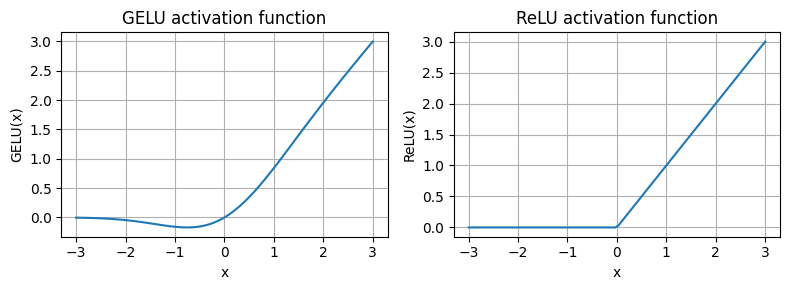

In [387]:
gelu, relu = GELU(), torch.nn.ReLU()

x = torch.linspace(-3, 3, steps=100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"])):
    plt.subplot(1,2,i+1)
    plt.plot(x,y, label=label)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [388]:
class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [389]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
out = ffn(x)
print("Output shape:", out.shape)

Output shape: torch.Size([2, 3, 768])


In [390]:
class ExampleDeepNeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super(ExampleDeepNeuralNetwork, self).__init__()

        self.use_shortcut = use_shortcut
        self.layers = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),  
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [391]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [392]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = torch.nn.MSELoss()(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean()}")

In [393]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [394]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [395]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = torch.nn.LayerNorm(cfg["emb_dim"])
        self.norm2 = torch.nn.LayerNorm(cfg["emb_dim"])
        self.drop_resid = torch.nn.Dropout(p=cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut
        return x

In [396]:
torch.manual_seed(123)
x = torch.randn(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [397]:
class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super(GPTModel, self).__init__()
        self.tok_emb = torch.nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = torch.nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = torch.nn.Dropout(p=cfg["drop_rate"])
        
        self.trf_blocks = torch.nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = torch.nn.LayerNorm(cfg["emb_dim"])
        self.out_head = torch.nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len).unsqueeze(0).repeat(batch_size,1))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [398]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch\n", batch)
print("\nOutput shape:", out.shape)
print("Output:\n", out)

Input batch
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
Output:
 tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [399]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

Total number of parameters in the model: 163,009,536


In [400]:
print(" Token embeddinng layer shape:", model.tok_emb.weight.shape)
print(" Output head layer shape:", model.out_head.weight.shape)

 Token embeddinng layer shape: torch.Size([50257, 768])
 Output head layer shape: torch.Size([50257, 768])


In [401]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.tok_emb.parameters())
print(f"Total number of parameters in GPT-2 with weight tying: {total_params_gpt2:,}")

Total number of parameters in GPT-2 with weight tying: 124,412,160


In [402]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total model size (float32): {total_size_mb:.2f} MB")

Total model size (float32): 621.83 MB


In [403]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [404]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded input:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
print("Encoded input tensor shape:", encoded_tensor.shape)

Encoded input: [15496, 11, 314, 716]
Encoded input tensor shape: torch.Size([1, 4])


In [405]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [406]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Generated text:\n", decoded_text)

Generated text:
 Hello, I am Featureiman Byeswickattribute argue


In [407]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "n_layers": 12,
    "n_heads": 12,
    "emb_dim": 768,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [408]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

In [409]:
def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

In [410]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [411]:
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

Generated text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


#### Text generation loss

In [412]:
inputs = torch.tensor([[16833, 3626, 6100], # [every effort moves]
                       [40, 1107, 588]]) #["I really like"]

In [413]:
targets = torch.tensor([[3626, 6100, 345], # [effort moves you]
                        [588, 428, 11311]])  # [really like chocolate]  

In [414]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print("Probas shape:", probas.shape)

Probas shape: torch.Size([2, 3, 50257])


In [415]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Predicted token IDs:\n", token_ids)

Predicted token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [416]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(start_dim=0), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Gathering SerbianFriday


In [417]:
torch.set_printoptions(sci_mode=True)
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Target probabilities batch 1:", target_probas_1)

Target probabilities batch 1: tensor([2.3466e-05, 2.0531e-05, 1.1733e-05])


In [418]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Target probabilities batch 1:", target_probas_2)

Target probabilities batch 1: tensor([1.3380e-05, 1.3445e-05, 1.1586e-05])


In [419]:
torch.set_printoptions(sci_mode=False)
log_probas = torch.log(torch.cat([target_probas_1, target_probas_2], dim=0))
print("Log probabilities of target tokens:", log_probas)

Log probabilities of target tokens: tensor([-10.6600, -10.7936, -11.3531, -11.2217, -11.2169, -11.3658])


In [420]:
avg_log__probas = torch.mean(log_probas)
print("Average log probability of target tokens:", avg_log__probas)

Average log probability of target tokens: tensor(-11.1018)


In [421]:
neg_avg_log_probas = avg_log__probas * -1
print("Negative average log probability (Cross-Entropy Loss):", neg_avg_log_probas)

Negative average log probability (Cross-Entropy Loss): tensor(11.1018)


#### Cross Entropy Loss

In [422]:
print("logits shape:", logits.shape)
print("targets shape:", targets.shape)

logits shape: torch.Size([2, 3, 50257])
targets shape: torch.Size([2, 3])


In [423]:
logits_flat = logits.flatten(start_dim=0, end_dim=1)
targets_flat = targets.flatten()
print("Flattened logits shape:", logits_flat.shape)
print("Flattened targets shape:", targets_flat.shape)

Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])


In [424]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross-Entropy Loss:", loss)

Cross-Entropy Loss: tensor(11.1018)


#### Perplexity

In [425]:
perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(66292.8359)


#### Training with variable lengths

In [426]:
with open(input_file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [427]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters in text: {total_characters}")
print(f"Total tokens in text: {total_tokens}")

Total characters in text: 20479
Total tokens in text: 5145


In [428]:
train_ratio = 0.9
split_idx = int(len(text_data) * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [429]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False
)

In [430]:
print("Train loader:")
for x, y in train_loader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

print("Validation loader:")
for x, y in val_loader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

Train loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Validation loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])


In [431]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(start_dim=0, end_dim=1),
        target_batch.flatten()
    )
    return loss

In [432]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [433]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Using device: cpu
Train Loss: 10.9885
Validation Loss: 10.9903


In [434]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [435]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model,
            idx = encoded,
            max_new_tokens = 50,
            context_size = context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()

In [436]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, Step {global_step:06d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        generate_and_print_sample(model, train_loader.dataset.tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [437]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.01)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Every effort moves you"
)


Epoch 1, Step 000000: Train Loss = 9.8964, Val Loss = 9.9327
Epoch 1, Step 000005: Train Loss = 7.9162, Val Loss = 8.3380
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2, Step 000010: Train Loss = 6.8458, Val Loss = 7.0472
Epoch 2, Step 000015: Train Loss = 5.9962, Val Loss = 6.6160
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Epoch 3, Step 000020: Train Loss = 5.6618, Val Loss = 6.6073
Epoch 3, Step 000025: Train Loss = 5.3515, Val Loss = 6.3413
Every effort moves you, and I had been.                                            
Epoch 4, Step 000030: Train Loss = 4.0013, Val Loss = 6.2778
Epoch 4, Step 000035: Train Loss = 2.5330, Val Loss = 6.2245
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Epoch 5, Step 000040: Train Loss = 3.8244, Val Loss = 6.1617
Every effor

In [438]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='Train Loss')
    ax1.plot(epochs_seen, val_losses, label='Validation Loss', linestyle='-.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens Seen')
    fig.tight_layout()
    plt.show()

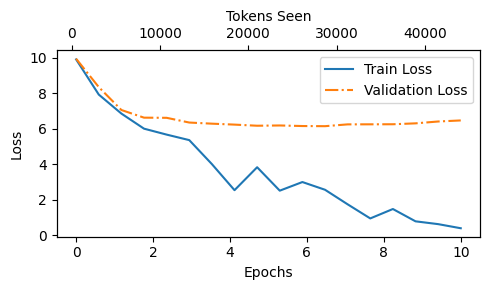

In [439]:
epochs_tensor = torch.linspace(0, num_epochs, steps=len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### Decoding strategies

##### Temperature scaling

In [440]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}


In [441]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id]) 

forward


In [442]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [444]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} X {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 X closer
0 X every
0 X effort
582 X forward
2 X inches
0 X moves
0 X pizza
343 X toward


##### Temperature Scaling

In [445]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

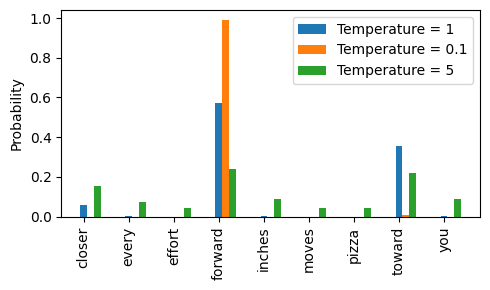

In [446]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, temp) for temp in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], width=bar_width, label=f"Temperature = {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

##### Top-k sampling

In [447]:
tok_k = 3
top_logits, top_pos = torch.topk(next_token_logits, tok_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [448]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print("New logits after top-k filtering:", new_logits)

New logits after top-k filtering: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [449]:
topk_probas = torch.softmax(new_logits, dim=-1)
print("Top-k probabilities:", topk_probas)

Top-k probabilities: tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### Text generation function

In [450]:
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            logits = torch.where(
                condition=logits < top_logits[:, -1],
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [451]:
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    temperature = 1.4,
    top_k = 25
)

In [452]:
print("Generated text with temperature and top-k sampling:\n", token_ids_to_text(token_ids, tokenizer))

Generated text with temperature and top-k sampling:
 Every effort moves youlit terrace.



" he said deprecating laugh


#### Loading and saving model weights

In [453]:
torch.save(model.state_dict(), "model.pth")

In [454]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): Transfo

##### Save both model and optimizer

In [455]:
torch.save({"model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            }, "model_and_optimizer.pth"
)

In [456]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.01)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): Transfo

#### Loading pretrained weights from OpenAI

In [458]:
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch05/"
       "01_main-chapter-code/gpt_download.py")

filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x11967afd0>)

In [460]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="models")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 66.8kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 983kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 132kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [03:08<00:00, 2.65MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.66MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 787kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 754kiB/s] 


In [461]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [462]:
print(params["wte"])
print("Token embedding weight tensor shape:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor shape: (50257, 768)


In [470]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12, "context_length": 1024, "qkv_bias": True},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16, "context_length": 1024, "qkv_bias": True},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20, "context_length": 1024, "qkv_bias": True},
    "gpt2-xl (1.5B)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25,  "context_length": 1024, "qkv_bias": True},
}

In [471]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [472]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'n_layers': 12,
 'n_heads': 12,
 'emb_dim': 768,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [473]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): Transform

In [520]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [521]:
def load_weights_into_gpt(gpt, params):
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=0)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b
        )
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        ) 

        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.weight = assign(
            gpt.trf_blocks[b].norm1.weight,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.bias = assign(
            gpt.trf_blocks[b].norm1.bias,
            params["blocks"][b]["ln_1"]["b"]
        )

        gpt.trf_blocks[b].norm2.weight = assign(
            gpt.trf_blocks[b].norm2.weight,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.bias = assign(
            gpt.trf_blocks[b].norm2.bias,
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.weight = assign(
        gpt.final_norm.weight,
        params["g"]
    )
    gpt.final_norm.bias = assign(
        gpt.final_norm.bias,
        params["b"]
    )
    gpt.out_head.weight = assign(
        gpt.out_head.weight,
        params["wte"]
    )

In [522]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): Transform

In [523]:
torch.manual_seed(123)
token_ids = generate(
    model = gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = NEW_CONFIG["context_length"],
    top_k = 50,
    temperature = 1.5
)
print("Generated text with GPT-2 weights:\n", token_ids_to_text(token_ids, tokenizer))

Generated text with GPT-2 weights:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


